In [95]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

In [96]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [97]:
import os
import sys

nb_dir_1 = os.path.split(os.getcwd())[0]
current_path = os.getcwd()
parent = os.path.dirname(current_path)
nb_dir_2 = os.path.split(parent)[0]

if nb_dir_1 not in sys.path:
    sys.path.append(nb_dir_1)

if nb_dir_2 not in sys.path:
    sys.path.append(nb_dir_2)

In [98]:
import numpy as np
import pandas as pd
import torch
from core.models import LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import scipy.stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from core.data_preparation import DataPreparation
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

In [99]:
# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [100]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [101]:
filepath = "../Data/BHARTIARTL_2010-01-012022-02-10.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,325.20
1,2010-01-05,330.35
2,2010-01-06,326.85
3,2010-01-07,329.40
4,2010-01-08,325.05


In [102]:
data.tail()

,date,close
3003,2022-02-03,721.65
3004,2022-02-04,720.20
3005,2022-02-07,706.50
3006,2022-02-08,708.90
3007,2022-02-09,719.35


In [103]:
data['close'].isnull().values.any()

False

In [104]:
# data[data['date'] == '2013-01-02'].index

In [105]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))

fig.update_layout(
    title="Airtel stock closing price from 2010 to January 2022",
    xaxis_title="Date",
    yaxis_title="Closing price in INR",    
    font=dict(
        family="Ariale",
        size=16       
    )
)

In [106]:
TsAD = importr('otsad')
TSdist = importr('TSdist')

In [107]:
train_len = 0.8*len(data)

In [108]:
res = TsAD.OcpTsSdEwma(data['close'].values, train_len, 0.01, 3, 20)

In [109]:
df = pd.DataFrame(res)

In [110]:
df.head()

,is.anomaly,lcl,ucl
0,0.0,325.20,325.20
1,0.0,330.35,330.35
2,0.0,326.85,326.85
3,0.0,329.40,329.40
4,0.0,325.05,325.05


In [111]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='close price'))
fig.add_trace(go.Scatter(x=df.index, y=df['lcl'], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index, y=df['ucl'], mode='lines', name='upper control limit'))

In [112]:
anomaly_indices = df[df['is.anomaly'] == 1.0].index

In [113]:
rows = data.iloc[anomaly_indices, :]

In [114]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))
fig.add_trace(go.Scatter(x=rows['date'], y=rows['close'], mode='markers', name='anomalies'))

In [115]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [116]:
train_set, test_set = prep.splitData(data['close'].values)

In [117]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (2386, 20, 1)
y_train.shape =  (2386, 1)
x_test.shape =  (582, 20, 1)
y_test.shape =  (582, 1)


In [118]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step() 

In [119]:
torch.save(model, 'lstm_airtel.pt')

In [120]:
actual_test_len = len(test_set) - window_size

In [121]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

Test Score: 0.04 MAPE
R-squared value is 0.7983097982310164
RMSE:  41.8582187107002


In [122]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-actual_test_len:], y=y_test[:,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['lcl'][-actual_test_len:], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['ucl'][-actual_test_len:], mode='lines', name='upper control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y= y_test_pred[:,0], mode='lines', name='predicted close price'))


#### Find distance between forecast distributions and actual test values using different distance measures from R

### Dynamic Time Warping

In [123]:
dtw_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(dtw.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "DTW distance" : dtw_dist

    }

df1 = pd.DataFrame(finalResult)

In [124]:
pdc_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  pdc = TSdist.PDCDistance(X1, X2)
  pdc_dist.append(pdc.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "PDC distance" : pdc_dist

    }

df2 = pd.DataFrame(finalResult)

In [125]:
cort_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  # print(X2.shape)

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  # print(type(X1))

  cort = TSdist.CortDistance(X1, X2, deltamethod="DTW")
  cort_dist.append(cort.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Temporal Correlation distance" : cort_dist

    }

df3 = pd.DataFrame(finalResult)

In [126]:
df3

,range,Temporal Correlation distance
0,0 : 100,575.817664
1,100 : 200,1297.097335
2,200 : 300,701.721514
3,300 : 400,863.836582
4,400 : 500,2912.039743


In [127]:
fourier_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  fourier = TSdist.FourierDistance(X1, X2)
  fourier_dist.append(fourier.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Fourier distance" : fourier_dist

    }

df4 = pd.DataFrame(finalResult)

In [128]:
df4

,range,Fourier distance
0,0 : 100,1051.979483
1,100 : 200,1460.678786
2,200 : 300,905.652117
3,300 : 400,1205.518818
4,400 : 500,4134.843338


#### KL divergence

In [129]:
def computeKLD(X1, X2, bins=5):

    # values_1, edges_1 = np.histogram(X1,bins=bins,density=True)
    # values_2, edges_2 = np.histogram(X2,bins=bins,density=True)

    values_1, edges_1 = np.histogram(X1,bins=bins)
    values_2, edges_2 = np.histogram(X2,bins=bins)
   
    #Consider only first std. deviation of original series i.e. P(x).    
    P = values_1
    Q = values_2
    delta_x = 2/bins
    res =  np.sum( P * np.log2( P/Q )) * delta_x
    return res

In [130]:
KLD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    kld_res = computeKLD(X1, X2)

    KLD.append(kld_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "KL divergence" : KLD

}

df5 = pd.DataFrame(finalResult)

#### Jensen Shannon Divergence

In [131]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    if len(p)>len(q):
        p = np.random.choice(p,len(q)) # random.choice make same length to p/q
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2

In [132]:
JSD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    jsd_res = jsd(X1, X2)

    JSD.append(jsd_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "JS divergence" : JSD

}

df6 = pd.DataFrame(finalResult)

In [133]:
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'],
 df4['Fourier distance'], df5['KL divergence'], df6['JS divergence']], axis=1)
result

,range,DTW distance,PDC distance,Temporal Correlation distance,Fourier distance,KL divergence,JS divergence
0,0 : 100,597.971954,0.551906,575.817664,1051.979483,1.810325,0.000111
1,100 : 200,1088.276672,0.924368,1297.097335,1460.678786,7.039978,0.000166
2,200 : 300,652.285370,0.952215,701.721514,905.652117,1.003938,0.000089
3,300 : 400,889.682312,0.636277,863.836582,1205.518818,3.860974,0.000080
4,400 : 500,2922.294617,0.980104,2912.039743,4134.843338,6.817321,0.000391


In [134]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-len(x_test):], y=data['close'][-len(x_test):], mode='lines', name='closing price'))

In [135]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[:100], y=y_test[:100,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[:100], y= y_test_pred[:100,0], mode='lines', name='predicted close price'))

In [136]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[100:200], y=y_test[100:200,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[100:200], y= y_test_pred[100:200,0], mode='lines', name='predicted close price'))

In [137]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[200:300], y=y_test[200:300,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[200:300], y= y_test_pred[200:300,0], mode='lines', name='predicted close price'))

In [138]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[300:400], y=y_test[300:400,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[300:400], y= y_test_pred[300:400,0], mode='lines', name='predicted close price'))

In [139]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[400:500], y=y_test[400:500,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[400:500], y= y_test_pred[400:500,0], mode='lines', name='predicted close price'))

#### Measure how accuracy of model changes with shift in test set

In [140]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*100} : {(i+1)*100}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df = pd.DataFrame(accuracy)

In [141]:
acc_df

,range,RMSE,MAPE,R2-score
0,0 : 100,14.204595,2.361488,0.940388
1,100 : 200,19.721917,2.783818,0.838658
2,200 : 300,12.786299,2.020033,0.914379
3,300 : 400,15.579171,2.145756,0.695787
4,400 : 500,48.629280,5.037661,0.539711


In [142]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(8):
    
    X1, X2 = gt[i*70 : (i+1)*70], preds[i*70 : (i+1)*70]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*70} : {(i+1)*70}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df2 = pd.DataFrame(accuracy)

In [143]:
acc_df2

,range,RMSE,MAPE,R2-score
0,0 : 70,13.631281,2.395231,0.882810
1,70 : 140,20.591997,3.208272,0.712642
2,140 : 210,15.584275,1.909661,-0.107580
3,210 : 280,13.764590,2.233878,0.890884
4,280 : 350,17.051566,2.356871,0.840156
5,350 : 420,10.234940,1.487524,0.401232
6,420 : 490,51.208987,5.421894,0.465768
7,490 : 560,87.266494,11.969945,-13.181632


In [144]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(11):
    
    X1, X2 = gt[i*50 : (i+1)*50], preds[i*50 : (i+1)*50]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*50} : {(i+1)*50}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df3 = pd.DataFrame(accuracy)

In [145]:
acc_df3

,range,RMSE,MAPE,R2-score
0,0 : 50,14.086376,2.608734,0.831933
1,50 : 100,14.321838,2.114241,0.839903
2,100 : 150,24.055279,3.736818,0.717158
3,150 : 200,14.115656,1.830819,-0.575109
4,200 : 250,14.251427,2.108940,0.904217
5,250 : 300,11.129946,1.931127,0.887012
6,300 : 350,18.912328,2.614799,0.635996
7,350 : 400,11.302434,1.676713,0.426297
8,400 : 450,8.698247,1.159638,0.311647
9,450 : 500,68.219899,8.915683,-1.054578


#### ECDF distance measures between actual values and forecasts

In [146]:
wasserstein_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Wasserstein_Dist(X1, X2)

    wasserstein_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Wasserstein distance" : wasserstein_distance

}

df7 = pd.DataFrame(finalResult)

In [147]:
KS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Kolmogorov_Smirnov_Dist(X1, X2)

    KS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Kolmogorov Smirnov distance" : KS_distance

}

df8 = pd.DataFrame(finalResult)

In [148]:
DTS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = DTS_Dist(X1, X2)

    DTS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "DTS distance" : DTS_distance

}

df9 = pd.DataFrame(finalResult)

In [149]:
result = pd.concat([df7, df8['Kolmogorov Smirnov distance'], df9['DTS distance']], axis=1)
result

,range,Wasserstein distance,Kolmogorov Smirnov distance,DTS distance
0,0 : 100,4.654086,0.09,1.028534
1,100 : 200,7.409528,0.21,1.808056
2,200 : 300,2.063493,0.05,0.456433
3,300 : 400,6.797672,0.23,1.541318
4,400 : 500,32.397690,0.37,6.585185


#### ECDF distance measures between train set and test set

In [150]:
dtw_dist = []
test_set_range = []

for i in range(8):

  X1, X2 = train_set, gt[i*70 : (i+1)*70]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(np.round(dtw.item(), 2))
  test_set_range.append(f'{i*70} : {(i+1)*70}')

finalResult_dtw = { "range" : test_set_range,    
    "DTW distance" : dtw_dist,

    }

df_dtw = pd.DataFrame(finalResult_dtw)

In [151]:
df_dtw

,range,DTW distance
0,0 : 70,90351.99
1,70 : 140,165608.33
2,140 : 210,437211.07
3,210 : 280,151981.97
4,280 : 350,295909.85
5,350 : 420,395109.50
6,420 : 490,436253.13
7,490 : 560,771206.10


In [152]:
def get_statistical_dist_measures(X_train, X_test):   

    CVM_distance = Cramer_Von_Mises_Dist(X_train, X_test)
    Anderson_Darling_distance = Anderson_Darling_Dist(X_train, X_test)
    Kolmogorov_Smirnov_distance = Kolmogorov_Smirnov_Dist(X_train, X_test)
    Kuiper_distance = Kuiper_Dist(X_train, X_test)
    Wasserstein_distance = Wasserstein_Dist(X_train, X_test)
    DTS_distance = DTS_Dist(X_train, X_test)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [153]:
test_set_range = []
finalResult = []

for i in range(5):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [154]:
test_set_range = []
finalResult2 = []

for i in range(8):
    
    X1, X2 = train_set, gt[i*70 : (i+1)*70]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult2.append(distances)
    test_set_range.append(f'{i*70} : {(i+1)*70}')



In [155]:
df = pd.DataFrame(finalResult)
# df.insert(0, 'Test set range', test_set_range)
frames = [acc_df[['RMSE',  'R2-score', 'MAPE']], df]
df = pd.concat(frames, axis=1)
df

#As distance between train and test increases, model's performance decreases. We should analyse this point here.
# Only DTS_dist and Wasserstein_dist are positively correlated to model's accuracy.

,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,14.204595,0.940388,2.361488,39.362389,737.741812,8.072019,0.689318,0.689318,107.644508
1,19.721917,0.838658,2.783818,49.098755,871.491895,14.713549,0.920981,0.920981,182.074011
2,12.786299,0.914379,2.020033,44.964873,831.531970,9.841624,0.876043,0.876043,133.599514
3,15.579171,0.695787,2.145756,50.733780,890.373275,16.262853,0.984206,0.984206,201.482007
4,48.629280,0.539711,5.037661,51.111497,893.276642,23.791808,0.991687,0.991687,249.501514


In [156]:
res = pd.concat([acc_df[['RMSE',  'R2-score', 'MAPE']], df[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist
0,14.204595,0.940388,2.361488,8.072019,107.644508,737.741812
1,19.721917,0.838658,2.783818,14.713549,182.074011,871.491895
2,12.786299,0.914379,2.020033,9.841624,133.599514,831.531970
3,15.579171,0.695787,2.145756,16.262853,201.482007,890.373275
4,48.629280,0.539711,5.037661,23.791808,249.501514,893.276642


In [157]:
df1 = pd.DataFrame(finalResult2)
df1.insert(0, 'Test set range', test_set_range)
df1

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,34.082806,665.224522,4.803516,0.674516,0.686569,77.611186
1,70 : 140,47.261884,839.845042,12.059799,0.912409,0.912409,151.299296
2,140 : 210,52.314084,883.842786,18.676185,0.994597,0.994597,214.430011
3,210 : 280,43.432492,803.685881,8.795763,0.862843,0.862843,120.512155
4,280 : 350,50.280118,866.052345,17.682769,0.971737,0.971737,195.066435
5,350 : 420,51.070182,875.069825,15.280460,0.986700,0.986700,186.867870
6,420 : 490,52.071511,881.318050,27.481219,0.992103,0.992103,254.730729
7,490 : 560,52.438495,884.703931,36.422538,1.000000,1.000000,354.343585


In [158]:
frames = [df1[['Test set range']], acc_df2[['RMSE',  'R2-score', 'MAPE']], df1.iloc[:, 1:]]
df1 = pd.concat(frames, axis=1)
df1


,Test set range,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,13.631281,0.882810,2.395231,34.082806,665.224522,4.803516,0.674516,0.686569,77.611186
1,70 : 140,20.591997,0.712642,3.208272,47.261884,839.845042,12.059799,0.912409,0.912409,151.299296
2,140 : 210,15.584275,-0.107580,1.909661,52.314084,883.842786,18.676185,0.994597,0.994597,214.430011
3,210 : 280,13.764590,0.890884,2.233878,43.432492,803.685881,8.795763,0.862843,0.862843,120.512155
4,280 : 350,17.051566,0.840156,2.356871,50.280118,866.052345,17.682769,0.971737,0.971737,195.066435
5,350 : 420,10.234940,0.401232,1.487524,51.070182,875.069825,15.280460,0.986700,0.986700,186.867870
6,420 : 490,51.208987,0.465768,5.421894,52.071511,881.318050,27.481219,0.992103,0.992103,254.730729
7,490 : 560,87.266494,-13.181632,11.969945,52.438495,884.703931,36.422538,1.000000,1.000000,354.343585


In [159]:
res = pd.concat([acc_df2[['RMSE',  'R2-score', 'MAPE']], df1[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']], df_dtw[['DTW distance']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist,DTW distance
0,13.631281,0.882810,2.395231,4.803516,77.611186,665.224522,90351.990000
1,20.591997,0.712642,3.208272,12.059799,151.299296,839.845042,165608.330000
2,15.584275,-0.107580,1.909661,18.676185,214.430011,883.842786,437211.070000
3,13.764590,0.890884,2.233878,8.795763,120.512155,803.685881,151981.970000
4,17.051566,0.840156,2.356871,17.682769,195.066435,866.052345,295909.850000
5,10.234940,0.401232,1.487524,15.280460,186.867870,875.069825,395109.500000
6,51.208987,0.465768,5.421894,27.481219,254.730729,881.318050,436253.130000
7,87.266494,-13.181632,11.969945,36.422538,354.343585,884.703931,771206.100000


In [160]:
test_set_range = []
finalResult3 = []

for i in range(11):
    
    X1, X2 = train_set, gt[i*50 : (i+1)*50]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult3.append(distances)
    test_set_range.append(f'{i*50} : {(i+1)*50}')



In [161]:
df3 = pd.DataFrame(finalResult3)
df3.insert(0, 'Test set range', test_set_range)
df3.head()

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 50,30.118341,598.094364,3.835895,0.661264,0.689942,63.949140
1,50 : 100,48.253358,838.347648,13.141079,0.969659,0.969659,154.052011
2,100 : 150,46.523781,822.081895,13.144731,0.900981,0.900981,145.627013
3,150 : 200,53.132870,874.812502,20.830190,1.000000,1.000000,218.484010
4,200 : 250,47.673746,830.052984,13.025266,0.936409,0.936409,150.932014


In [162]:
y_values = 100 - acc_df2['MAPE']
# y_values

In [163]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=y_values, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (100-MAPE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [164]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=df1['RMSE'], labels=dict(x="Dissimilarity (Wasserstein distance)", y="Performance (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

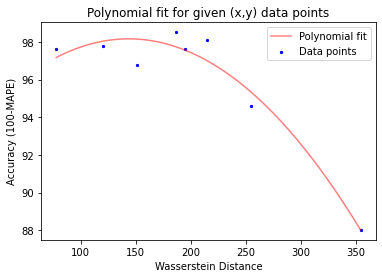

In [167]:
fit_polynomial_curve_to_data_and_visualize(df1['Wasserstein_dist'].values, y_values, xlabel='Wasserstein Distance', ylabel='Accuracy (100-MAPE)')

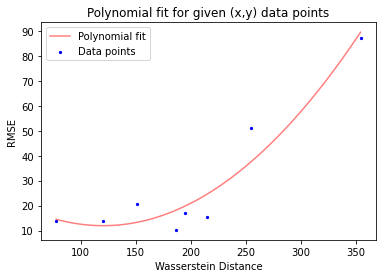

In [168]:
fit_polynomial_curve_to_data_and_visualize(df1['Wasserstein_dist'].values, df1['RMSE'].values, xlabel='Wasserstein Distance', ylabel='RMSE')

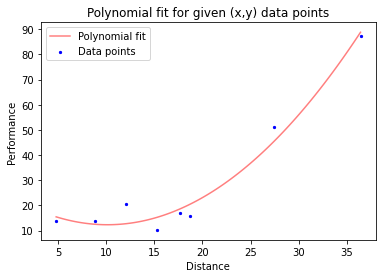

In [169]:
fit_polynomial_curve_to_data_and_visualize(df1['DTS_dist'].values, df1['RMSE'].values)